In [25]:
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from gensim.parsing.preprocessing import remove_stopwords, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, strip_short, stem_text
import re
from spacy.lang.en import English
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import preprocessing
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/danielkashkett/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [26]:
def import_data(dir_path):
    # file paths
    crowd_train_posts_path = dir_path + "/crowd/train/shared_task_posts.csv"
    crowd_test_posts_path = dir_path + "/crowd/test/shared_task_posts_test.csv"
    crowd_train_labels_path = dir_path + "/crowd/train/crowd_train.csv"
    crowd_test_labels_path = dir_path + "/crowd/test/crowd_test.csv"

    # read in files
    print("...fetching data...")
    train_posts = pd.read_csv(crowd_train_posts_path)
    train_labels = pd.read_csv(crowd_train_labels_path)
    test_posts = pd.read_csv(crowd_test_posts_path)
    test_labels = pd.read_csv(crowd_test_labels_path)

    print("...preparing dataset...")
    # fix column name for test_labels
    test_labels.columns = ["user_id", "label"]
    # merge csv into datasets for train and test
    train_data = pd.merge(train_posts, train_labels, on=["user_id"])
    test_data = pd.merge(test_posts, test_labels, on=["user_id"])
    # drop rows that have NaN values for
    train_data = train_data.dropna()
    test_data = test_data.dropna()
    # binarize labels
    train_data["label"] = train_data.label.map({"a": 0, "b": 0, "c": 0, "d": 1})
    test_data["label"] = test_data.label.map({"a": 0, "b": 0, "c": 0, "d": 1})

    # combine data
    combined_data = pd.concat([train_data, test_data])
    combined_data = combined_data.drop(
        ["post_id", "timestamp"], axis=1
    )
    print("...imported successfully.")
    print("")

    return combined_data

def clean_post(post):
    return re.sub("[^a-zA-Z]+", " ", post).lower()

def tokenize(post, nlp=English()):
    doc = nlp(post)
    tokens = [token.orth_.lower() for token in doc if not token.is_space]
    return tokens

def make_ngrams(tokens, n):
    return list(nltk.ngrams(tokens, n))

def make_unigrams(post, nlp=English()):
    doc = nlp(post)
    unigrams = [
        token.orth_.lower()
        for token in doc
        if not token.is_digit
        and not token.is_punct
        and not token.is_stop
        and not token.is_space
    ]
    return unigrams

def filter_stopword_ngrams(ngram_list):
    filtered = []
    for ngram in ngram_list:
        s = ' '.join(ngram)
        s2 = remove_stopwords(s)
        if len(s) == len(s2):
            filtered.append('_'.join(s2.split()))
    return filtered


def count_ngrams(posts, n=2):
    d = Counter()
    print("...counting ngrams...")
    for post in posts:
        post = clean_post(post)
        tokens = tokenize(post)
        ngrams = make_ngrams(tokens, n)
        filtered_ngrams = filter_stopword_ngrams(ngrams)
        d.update(filtered_ngrams)
    print("...finished successfully.")
    return d


def sort_ngram_count_results(counter, n=20, asc=False):
    frame = pd.DataFrame({"ngram": counter.keys(), "freq": counter.values()})
    sorted_frame = (
        frame.sort_values(by="freq", ascending=asc)
        .reset_index()
        .drop(["index"], axis=1)
        .head(n)
    )
    return sorted_frame


def compare_counts(counters):
    frame = pd.concat(counters, axis=1)
    frame.columns = ["suicidal", "freq", "non-suicidal", "freq"]
    return frame

In [27]:
# import data
data = import_data('./umd_reddit_suicidewatch_dataset_v2')
data.head()

...fetching data...
...preparing dataset...
...imported successfully.



,user_id,subreddit,post_title,post_body,label
0,22002,GetMotivated,[real] motivation,This is my first post on reddit. Some time ago...,0
1,22002,leagueoflegends,simple question about transfering acc to anoth...,Hi.. What will happen with my ranked rating? I...,0
3,22002,leagueoflegends,simple question: Did you get unnbaned?,Hi. Simple question. Did you get unban from a ...,0
4,22002,leagueoflegends,I can't win. Why... and it's noy my fault.,Hi... Am playing at Eu west... am diamond 5 ri...,0
5,22002,leagueoflegends,Diamond 5. Mrr rest,If i will switch server to EU and then go back...,0


In [28]:
# split data
#split the data
X_train, X_test, y_train, y_test = train_test_split(data.drop(['label'],axis=1), data['label'], 
                                                    test_size=0.15, stratify = data['label'], shuffle=True,random_state=3)

In [29]:
# rebalance training data
def rebalance_train(X_train, y_train, X_test, y_test):
    train = X_train
    train['label'] = y_train
    pos, neg = train[train['label']==1], train[train['label']==0]
    neg = neg.iloc[:pos.shape[0]]
    train = pd.concat([pos,neg]).values
    np.random.shuffle(train)
    train = pd.DataFrame(train, columns=['user_id','subreddit','post_title','post','label'])
    test = test = X_test
    test['label'] = y_test
    test.columns = ['user_id','subreddit','post_title','post','label']
    return train, test

train, test = rebalance_train(X_train, y_train, X_test, y_test)

In [30]:
# feature engineering
train['len_of_title'] = train['post_title'].map(len)
test['len_of_title'] = test['post_title'].map(len)
train['len_of_post'] = train['post'].map(len)
test['len_of_post'] = test['post'].map(len)
# dictionary of post count by user_id
user_freq = Counter(train['user_id'])
train['user_freq'] = [user_freq[i] for i in train['user_id']]
test['user_freq'] = [user_freq[i] for i in test['user_id']]

In [31]:
# split training data into positive and negative samples for analysis
pos = train[train['label']==1]
neg = train[train['label']==0]

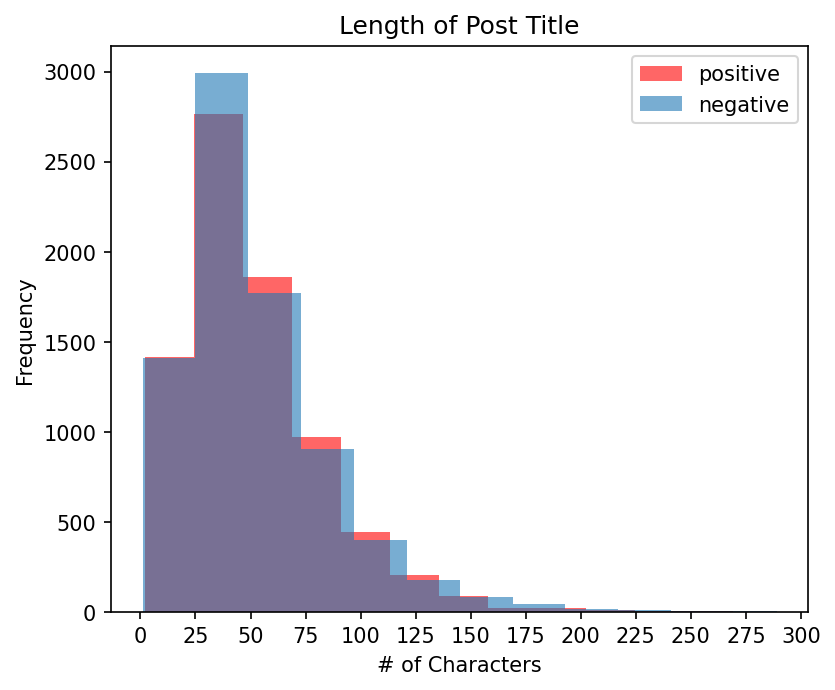

In [32]:
plt.figure(figsize=(6,5),dpi=150)
plt.hist(pos['len_of_title'],alpha=0.6, color='red', bins=12, label='positive')
plt.hist(neg['len_of_title'], alpha=0.6, bins=12, label = 'negative')
plt.legend()
plt.title('Length of Post Title')
plt.xticks(np.arange(0,310,25))
plt.xlabel('# of Characters')
plt.ylabel('Frequency')
plt.savefig('./plots/length_of_title')

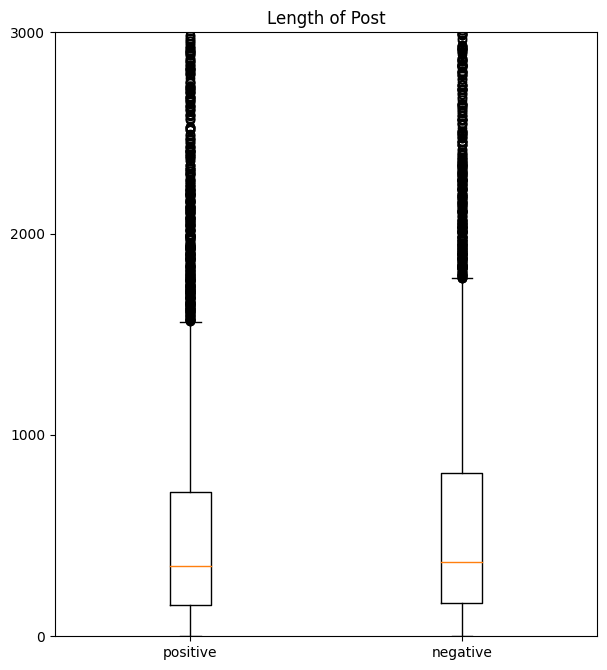

In [33]:
plt.figure(figsize=(7,8),dpi=100)
plt.ylim([0,3000])
plt.yticks(np.arange(0,4000,1000))
plt.boxplot([pos['len_of_post'],neg['len_of_post']],labels=['positive','negative'])
plt.title('Length of Post')
plt.savefig('./plots/length_of_post')

In [34]:
pos_vocab = Counter()
neg_vocab = Counter()
pos_titles = pos['post_title'].values
neg_titles = neg['post_title'].values

for title in pos_titles:
    unigrams = make_unigrams(title)
    pos_vocab.update(unigrams)

for title in neg_titles:
    unigrams = make_unigrams(title)
    neg_vocab.update(unigrams)
    
top_pos_titles = [i[0] for i in pos_vocab.most_common(10)]
top_pos_titles_freq = [i[1] for i in pos_vocab.most_common(10)]
pos_titles_df = pd.DataFrame({'word':top_pos_titles,'freq':top_pos_titles_freq})
top_neg_titles = [i[0] for i in neg_vocab.most_common(10)]
top_neg_titles_freq = [i[1] for i in neg_vocab.most_common(10)]
neg_titles_df = pd.DataFrame({'word':top_neg_titles,'freq':top_neg_titles_freq})

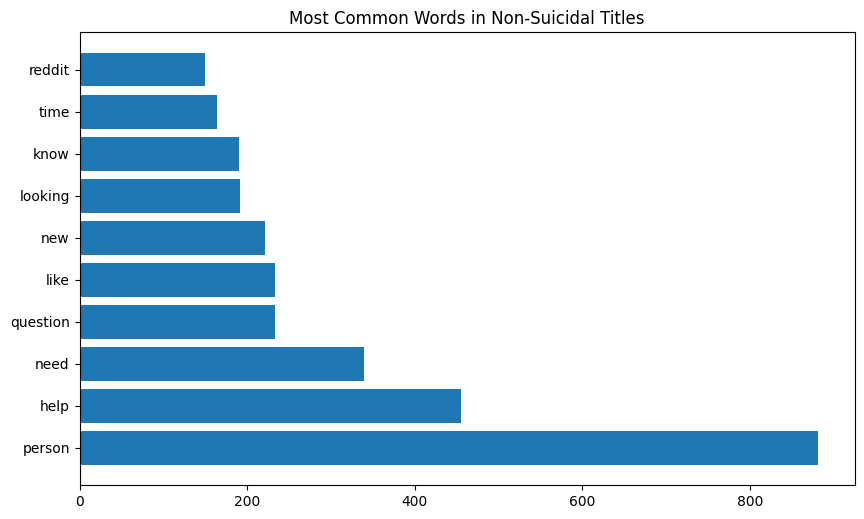

In [35]:
plt.figure(figsize=(10,6), dpi=100)
plt.barh(neg_titles_df['word'], width=neg_titles_df['freq'])
plt.title('Most Common Words in Non-Suicidal Titles')
plt.savefig('./plots/non_suicidal_titles')

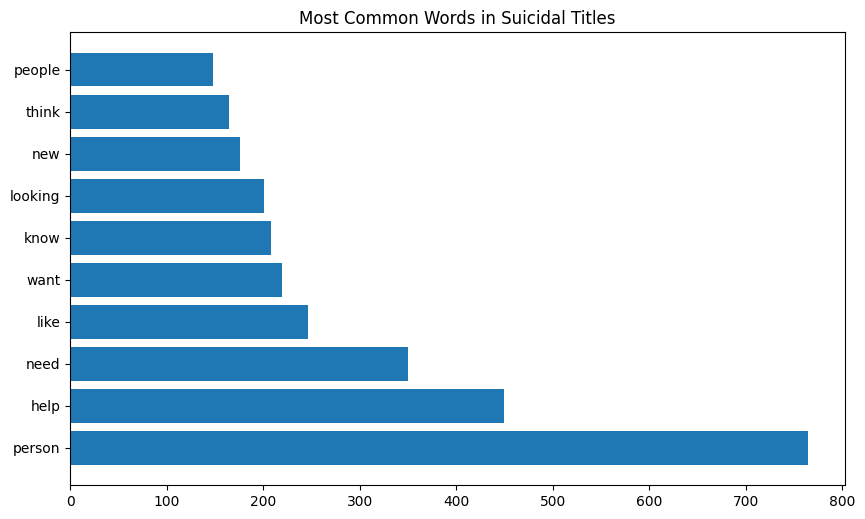

In [36]:
plt.figure(figsize=(10,6), dpi=100)
plt.barh(pos_titles_df['word'], width=pos_titles_df['freq'])
plt.title('Most Common Words in Suicidal Titles')
plt.savefig('./plots/suicidal_titles')

In [37]:
pos_vocab = Counter()
neg_vocab = Counter()
pos_posts = pos['post'].values
neg_posts = neg['post'].values

for post in pos_posts:
    unigrams = make_unigrams(post)
    pos_vocab.update(unigrams)

for post in neg_posts:
    unigrams = make_unigrams(post)
    neg_vocab.update(unigrams)
    
top_pos_posts = [i[0] for i in pos_vocab.most_common(30)]
top_pos_posts_freq = [i[1] for i in pos_vocab.most_common(30)]
pos_posts_df = pd.DataFrame({'word':top_pos_posts,'freq':top_pos_posts_freq})
top_neg_posts = [i[0] for i in neg_vocab.most_common(30)]
top_neg_posts_freq = [i[1] for i in neg_vocab.most_common(30)]
neg_posts_df = pd.DataFrame({'word':top_neg_posts,'freq':top_neg_posts_freq})

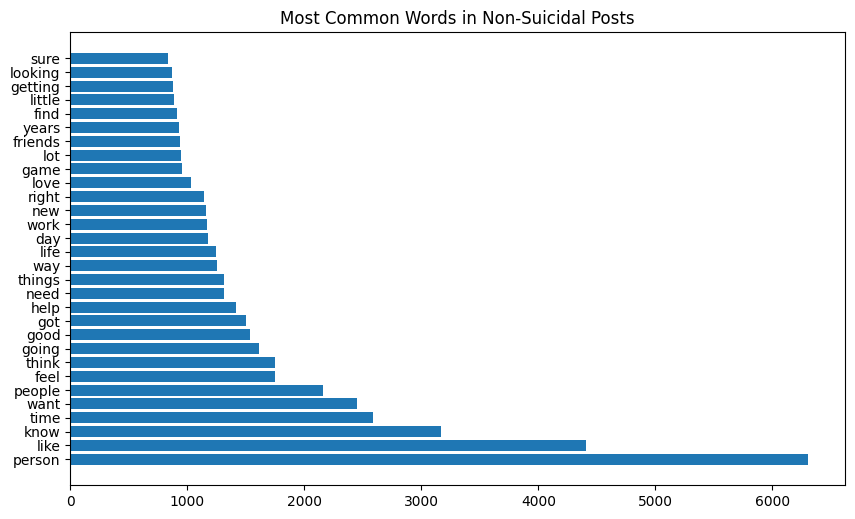

In [38]:
plt.figure(figsize=(10,6), dpi=100)
plt.barh(neg_posts_df['word'], width=neg_posts_df['freq'])
plt.title('Most Common Words in Non-Suicidal Posts')
plt.savefig('./plots/non_suicidal_posts')

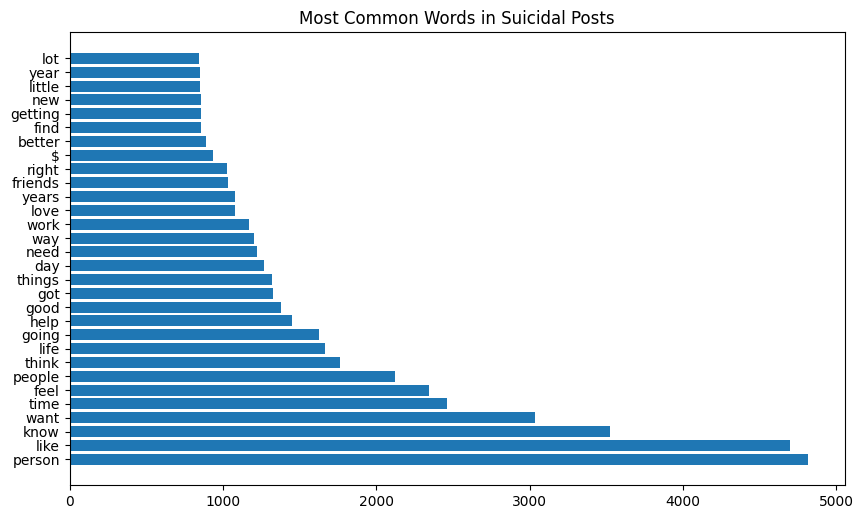

In [39]:
plt.figure(figsize=(10,6), dpi=100)
plt.barh(pos_posts_df['word'], width=pos_posts_df['freq'])
plt.title('Most Common Words in Suicidal Posts')
plt.savefig('./plots/suicidal_posts')

# Compare Ngrams

In [40]:
# Get Bigrams for each class
pos_bigram_counts = count_ngrams(pos['post'])
neg_bigram_counts = count_ngrams(neg['post'])

...counting ngrams...
...finished successfully.
...counting ngrams...
...finished successfully.


In [41]:
# sort counts
pos_bigram_counts = sort_ngram_count_results(pos_bigram_counts,n=200).iloc[25:]
neg_bigram_counts = sort_ngram_count_results(neg_bigram_counts,n=200).iloc[25:]

In [88]:
ngram_comparisson = compare_counts([pos_bigram_counts,neg_bigram_counts])
ngram_comparisson.head(25).iloc[1:]

,suicidal,freq,non-suicidal,freq
26,years_ago,136,m_trying,122
27,ve_tried,129,ca_nt,112
28,hasn_t,125,t_feel,111
29,feels_like,124,ve_tried,111
30,t_care,123,long_time,106
31,years_old,122,s_going,105
32,ca_nt,121,m_sure,104
33,s_like,120,hasn_t,103
34,s_going,116,shouldn_t,95
35,t_help,116,years_old,95


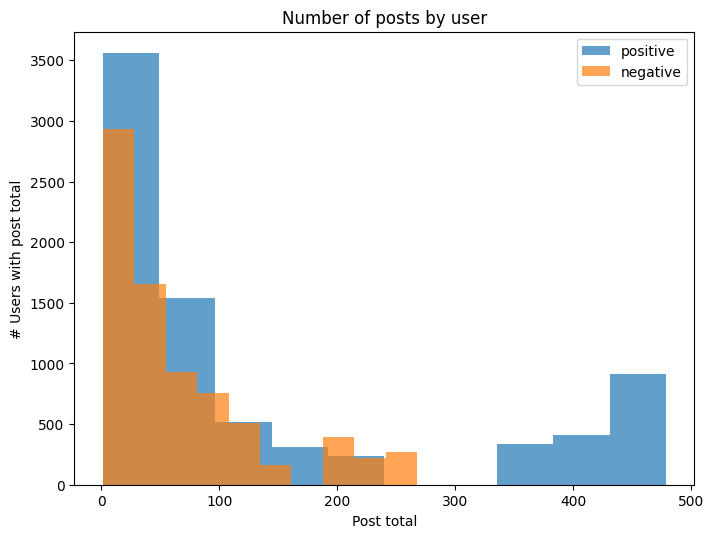

In [43]:
plt.figure(figsize=(8,6),dpi=100)
plt.hist(pos.user_freq, label='positive', alpha=0.7)
plt.hist(neg.user_freq, label='negative', alpha =0.7)
plt.legend()
plt.ylabel('# Users with post total')
plt.xlabel('Post total')
plt.title('Number of posts by user')
plt.savefig('./plots/user_freq')

In [87]:
# most common subreddits in dataset
Counter(data.subreddit).most_common(20)

[('AskReddit', 1300),
 ('SuicideWatch', 1028),
 ('depression', 650),
 ('trees', 375),
 ('offmychest', 309),
 ('leagueoflegends', 280),
 ('teenagers', 236),
 ('MLPLounge', 221),
 ('buildapc', 213),
 ('Random_Acts_Of_Amazon', 205),
 ('selfharm', 176),
 ('gaming', 159),
 ('AskWomen', 159),
 ('tipofmytongue', 146),
 ('techsupport', 146),
 ('BabyBumps', 146),
 ('self', 142),
 ('Fireteams', 138),
 ('summonerschool', 137),
 ('Fitness', 127)]

In [68]:
user1 = train[(train['label']==1) & (train['user_id']==4132)]['post'].values

In [69]:
user2 = pos[pos.user_id==28983]['post'].values

In [63]:
user4132[9]

'my brother was in intnse care because he slit his wrist. we just got a call that he passed on.**Kyle was adopted and when my mom and step-dad got a divorce he went back to roaming from place to place. When he was a kid he ran away from his moms house, then child services took him away becasue she beat him alot. When my mom adopted him he was doing drugs and some other stupid stuff. After the divorce the rest of the family stopped talking to him and I am the only one who kept in touch. He was in and out of jail alot again before one day he just kinda had enough I guess and broke down.'

In [85]:
user2[4]

'TLDR; Looking to move to texas. fire away!'